# Internship Skill Trend Analysis using JobBERT (Named Entity Recognition)

**Goal:** The goal of this project is to extract internship-related skills for students using the BERT model. BERT itself does not officially have a model called “JobBERT”, but many researchers and companies have created models called JobBERT by fine-tuning BERT on job-related data.

In other way, **JobBERT** is a domain-specific version of BERT that is trained or fine-tuned on job-related text such as job postings, resumes, and skill descriptions. It uses the same Transformer encoder architecture as BERT, but learns representations that better capture job titles, skills, and labor-market terminology. JobBERT is commonly used for tasks like resume–job matching, skill extraction, and job recommendation systems.
We will use these **two models**:


https://huggingface.co/jjzha/jobbert_skill_extraction

https://huggingface.co/jjzha/jobbert_knowledge_extraction





---




**Dataset Used:** https://www.kaggle.com/datasets/ivankmk/thousand-ml-jobs-in-usa/data


---


The project is implemented in **two approaches**:

**(1)** Extracting skills from real job description postings Dataset.

**(2)** Extracting skills from student Resumes.









## **Data Loading and Preprocessing**

In [89]:

!pip install -q transformers torch pandas
!pip install bertopic sentence-transformers umap-learn hdbscan


In [50]:
import pandas as pd
import re
from transformers import pipeline
import seaborn as sns
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import re

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [51]:
print_debug = True
csv_file = "/content/1000_ml_jobs_us.csv"
df = pd.read_csv(csv_file)
df.head(5)

,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer


In [52]:
df.isnull().sum()

,0
Unnamed: 0,0
job_posted_date,0
company_address_locality,47
company_address_region,113
company_name,0
company_website,14
company_description,12
job_description_text,1
seniority_level,9
job_title,0


In [53]:
df['seniority_level'].unique()

array(['Internship', 'Mid-Senior level', 'Entry level', 'Not Applicable',
       'Associate', nan, 'Executive', 'Director'], dtype=object)

In [54]:
#keep only required col
df = df[["seniority_level", "job_description_text"]]


df = df.dropna(subset=["seniority_level", "job_description_text"])

if print_debug:
    print(df.head(5))
    print("Total rows:", len(df))


    seniority_level                               job_description_text
0        Internship  OverviewUpper Hand is embarking on an exciting...
1  Mid-Senior level  Company DescriptionThe Ikigai platform unlocks...
2       Entry level  Our CompanyChanging the world through digital ...
3       Entry level  Waymo is an autonomous driving technology comp...
4  Mid-Senior level  Job Title: Machine Learning EngineerLocation: ...
Total rows: 988


In [55]:
df["seniority_level_clean"] = df["seniority_level"].astype(str).str.lower().str.strip()

df_intern = df[df["seniority_level_clean"].str.contains(r"\bintern\b|\binternship\b", regex=True)].copy()

print("Internship rows:", len(df_intern))

if print_debug:
    print(df_intern[["seniority_level"]].head(10))


Internship rows: 70
   seniority_level
0       Internship
5       Internship
24      Internship
28      Internship
36      Internship
44      Internship
57      Internship
58      Internship
60      Internship
62      Internship


In [56]:

def clean_text(text: str) -> str:
    text = str(text)
    # text = str(text).lower()
    text = re.sub(r"<.*?>", " ", text)#remove HTML tags
    text = re.sub(r"\s+", " ", text)#ormalize whitespace
    return text.strip()

# 'job_description_text_clean' is with lower case
df_intern["job_description_text_clean"] = df_intern["job_description_text"].apply(clean_text)


if print_debug:
    display(
        df_intern[
            ["job_description_text", "job_description_text_clean"]
        ].head(10)
    )


,job_description_text,job_description_text_clean
0,OverviewUpper Hand is embarking on an exciting...,OverviewUpper Hand is embarking on an exciting...
5,Our CompanyChanging the world through digital ...,Our CompanyChanging the world through digital ...
24,Our CompanyChanging the world through digital ...,Our CompanyChanging the world through digital ...
28,Our CompanyChanging the world through digital ...,Our CompanyChanging the world through digital ...
36,ResponsibilitiesTikTok is the leading destinat...,ResponsibilitiesTikTok is the leading destinat...
44,About Moloco:Moloco is a machine learning comp...,About Moloco:Moloco is a machine learning comp...
57,"Department: PayloadLocation: Irvine, Californi...","Department: PayloadLocation: Irvine, Californi..."
58,ResponsibilitiesTikTok is the leading destinat...,ResponsibilitiesTikTok is the leading destinat...
60,Please NoteTo provide the best candidate exper...,Please NoteTo provide the best candidate exper...
62,Company Overview:Bose Professional is a leader...,Company Overview:Bose Professional is a leader...


## **Dataset Visualizing**

In [57]:
df2 = pd.read_csv(csv_file)

df2 = df2.dropna(subset=["seniority_level"])
df2["seniority_level_clean"] = df2["seniority_level"].astype(str).str.lower().str.strip()

df2_intern = df2[
    df2["seniority_level_clean"].str.contains(r"\bintern\b|\binternship\b", regex=True)
].copy()


### Top 10 Companies offering Internship

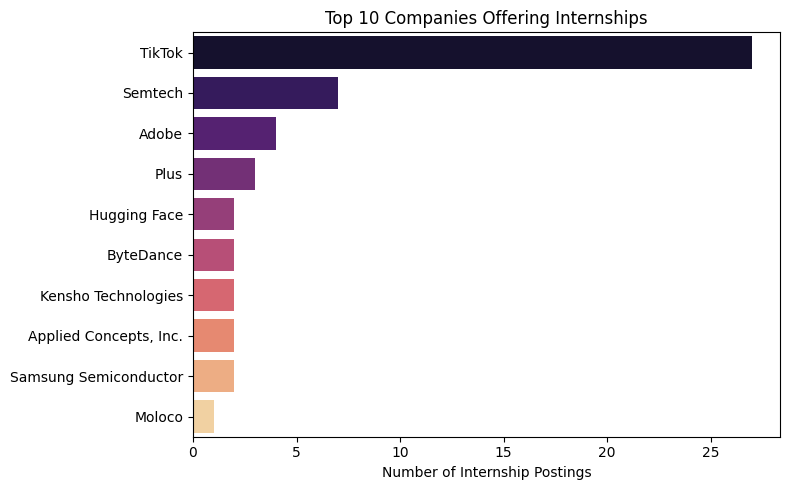

In [58]:
df_comp = df2_intern.dropna(subset=["company_name"])

top_intern_companies = df_comp["company_name"].value_counts().nlargest(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_intern_companies.values,
    y=top_intern_companies.index,
    palette="magma"
)
plt.title("Top 10 Companies Offering Internships")
plt.xlabel("Number of Internship Postings")
plt.ylabel("")
plt.tight_layout()
plt.show()


### Top 10 Regions with Most Internship Job Postings

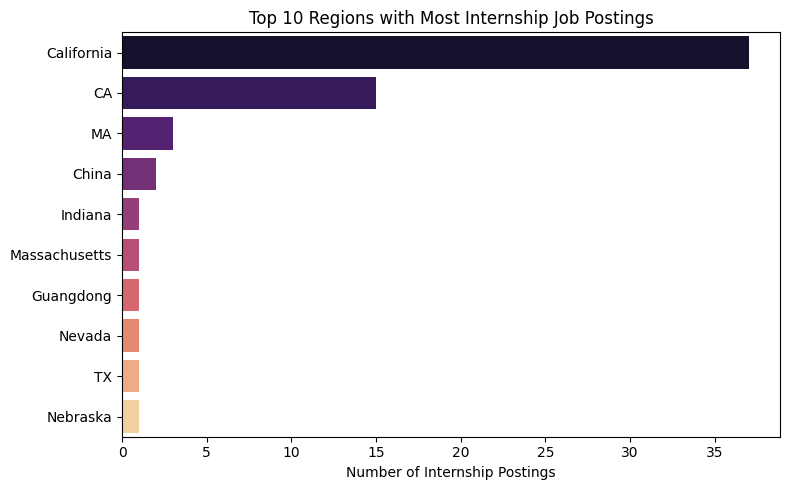

In [59]:
df_reg = df2_intern.dropna(subset=["company_address_region"])

top_regions = df_reg["company_address_region"].value_counts().nlargest(10).index
df_top = df_reg[df_reg["company_address_region"].isin(top_regions)]

plt.figure(figsize=(8, 5))
sns.countplot(
    y="company_address_region",
    data=df_top,
    order=top_regions,
    palette="magma"
)
plt.title("Top 10 Regions with Most Internship Job Postings")
plt.xlabel("Number of Internship Postings")
plt.ylabel("")
plt.tight_layout()
plt.show()

## **Skill Extraction From Job Description posts using JobBert**

The pre-trained JobBERT models are used to analyze job descriptions and identify skill-related words and phrases. One model focuses on general skills(Soft Skills), while the other focuses on technical knowledge(Hard Skills). Related words are grouped together so that complete skill names are extracted instead of isolated terms.

In [60]:
# load JobBERT NER models
soft_skill_pipeline = pipeline(
    model="jjzha/jobbert_skill_extraction",
    aggregation_strategy="first"
)

hard_skill_pipeline = pipeline(
    model="jjzha/jobbert_knowledge_extraction",
    aggregation_strategy="first"
)


Device set to use cuda:0
Device set to use cuda:0


In [61]:
#load tokenizer and models
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

soft_model_name = "jjzha/jobbert_skill_extraction"
hard_model_name = "jjzha/jobbert_knowledge_extraction"

tokenizer = AutoTokenizer.from_pretrained(soft_model_name)

soft_model = AutoModelForTokenClassification.from_pretrained(soft_model_name).to(device)
hard_model = AutoModelForTokenClassification.from_pretrained(hard_model_name).to(device)

soft_model.eval()
hard_model.eval()


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

We split long text into smaller overlapping token chunks so that it fits within BERT’s input length limit. The overlap helps preserve context between chunks and prevents information loss at chunk boundaries.

In [62]:
def chunk_token_ids(text, max_tokens=510, stride=100):
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    chunks = []

    start = 0
    while start < len(token_ids):
        end = min(start + max_tokens, len(token_ids))
        chunks.append(token_ids[start:end])

        if end == len(token_ids):
            break
        start = end - stride

    return chunks


We pass tokenized text into the trained model to predict a label for each token. The model output is converted into human-readable labels, allowing us to identify which tokens correspond to named entities such as skills.

In [63]:
def ner_from_model(token_ids, model):
    input_ids = tokenizer.build_inputs_with_special_tokens(token_ids)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

    attention_mask = torch.ones_like(input_ids).to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)[0]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    labels = [model.config.id2label[p.item()] for p in preds]

    return tokens, labels



We combine consecutive tokens that are labeled as entities into complete phrases. This allows us to reconstruct full skill names from individual token predictions and remove duplicates from the final results.

In [64]:
def extract_entities(tokens, labels):
    entities = []
    current = []

    for token, label in zip(tokens, labels):
        if label != "O" and not token.startswith("##"):
            current.append(token.replace("##", ""))
        else:
            if current:
                entities.append(" ".join(current))
                current = []

    if current:
        entities.append(" ".join(current))

    return list(set(entities))

We split each job description into smaller chunks and apply the trained models to each chunk to extract skill-related entities. The extracted entities are combined and deduplicated to produce a final list of skills identified across the entire text.

In [65]:
def extract_skills_ner(text):
    soft_skills = set()
    hard_skills = set()

    chunks = chunk_token_ids(text)

    for chunk in chunks:
        s_tokens, s_labels = ner_from_model(chunk, soft_model)
        h_tokens, h_labels = ner_from_model(chunk, hard_model)

        soft_skills.update(extract_entities(s_tokens, s_labels))
        hard_skills.update(extract_entities(h_tokens, h_labels))

    return sorted(soft_skills), sorted(hard_skills)



We apply the skill extraction function to each internship job description and store the identified skills in new columns of the dataset. During processing, intermediate results are printed for verification, and a preview of the extracted skills is displayed for inspection.

In [66]:
df_intern["soft_skills"] = ""
df_intern["hard_skills"] = ""

for idx, row in df_intern.iterrows():
    soft, hard = extract_skills_ner(row["job_description_text_clean"])

    df_intern.at[idx, "soft_skills"] = soft
    df_intern.at[idx, "hard_skills"] = hard

    if print_debug:
        print(f"Row index: {idx}")
        print("Soft skills:", soft)
        print("Hard skills:", hard)
        print("-" * 60)

display(
    df_intern[
        ["seniority_level", "soft_skills", "hard_skills"]
    ].head(10)
)



Row index: 0
Soft skills: [',', ', and monitoring machine learning models in real - world applications', ', deploy , and maintain s', ', or related', '-', 'AI - driven initiatives', 'C', 'Col', 'Data Science', 'Dev', 'Science', 'Spa', 'Support continuous improvement', 'Work closely with external clients and internal cross - functional teams', 'al', 'analytical skills', 'and readiness for model training . Use data science techniques', 'and work', 'as Data', 'at communicating complex technical', 'boundaries', 'build cutting - edge machine learning models', 'building , deploy', 'building and deploy', 'communicate model results and recommendations to both technical and non - technical audiences', 'communicating complex technical concepts', 'data', 'data pipeline', 'data w', 'deploy', 'develop data - driven insights', 'diverse audiences and', 'drive business decision - making', 'energetic', 'ensure data access', 'ensuring they al', 'extract insights', 'feature', 'impact', 'improve predictio

,seniority_level,soft_skills,hard_skills
0,Internship,"[,, , and monitoring machine learning models i...","[A, AI, Computer Science, Data, Data Science, ..."
5,Internship,"[, efficient, Dev, and, communication , relati...","[., AI, Adobe . com, Computer, Computer Engine..."
24,Internship,"[, scale up ,, Col, bring research ideas to pr...","[$, AI, C + +, Computer Engineering, Computer ..."
28,Internship,"[,, , efficient ,, Dev, and implement s, commu...","[AI, Adobe, Computer Engineering, Computer Sci..."
36,Internship,"[Co, Co - create a future driven, formula, job...","[; auction, Bachelor, C / C + +, Computer Engi..."
44,Internship,"[Building, coding, problem solving]","[/, / Data, Bachelor ' s, Bachelor ' s , Maste..."
57,Internship,"[, develop , and valid, Con, a novel research ...","[A, Bachelor ' s, C + +, Computer Vision, Data..."
58,Internship,"[Effect, Ex, Inter, and, communication, contac...","[C, Computer Engineering, Computer Science, LL..."
60,Internship,"[, and models, - motivated, /, ?, Co, Complete...","[+, ,, Computer Science, Hu, I, IP, Ke, No, P,..."
62,Internship,"[, and analyzing data, , and results, and op, ...","[- Lea, ; N, Computer Science, Electrical Engi..."


**Output:** Several correct and meaningful skills were successfully identified. For soft skills, examples of correct extractions include **'Problem solving'**, **'Communication'**, **'Critical Thinking'**, and **'Quantitative Problem-solving Ability'**


For Hard Skills, the model correctly identified well-defined technical skills such as **'Java', 'Statistics', 'R', 'machine learning', 'deep learning', 'C++', 'signal processing', and 'Computer Vision'.** Etc.


However, the results also reveal significant noise and partial extractions, particularly for soft skills. Many extracted soft skills are incomplete or fragmented, such as **“- solving”** instead of **“problem-solving skills”**, or truncated phrases like **“Dev”, “Col”, “contact”**, and **“communication , relationship skills”**. This indicates that the model often captures only parts of longer expressions rather than full, semantically complete skill phrases.

A similar issue appears in the hard skills output. While many technical skills are correct, there are also invalid or ambiguous tokens such as **“G”, “P”, “S”, “Spa”, “bill”,** and domain-specific but non-skill phrases like **“ads ranking”**. These errors suggest that the token-level nature of the model sometimes misclassifies abbreviations, single characters, or contextual terms as skills.

### **Knowledge Graph**

An initial co-occurrence visualization was created using a spring-layout graph. However, due to remaining density and overlap, additional filtering and an alternative layout were applied to improve interpretability.

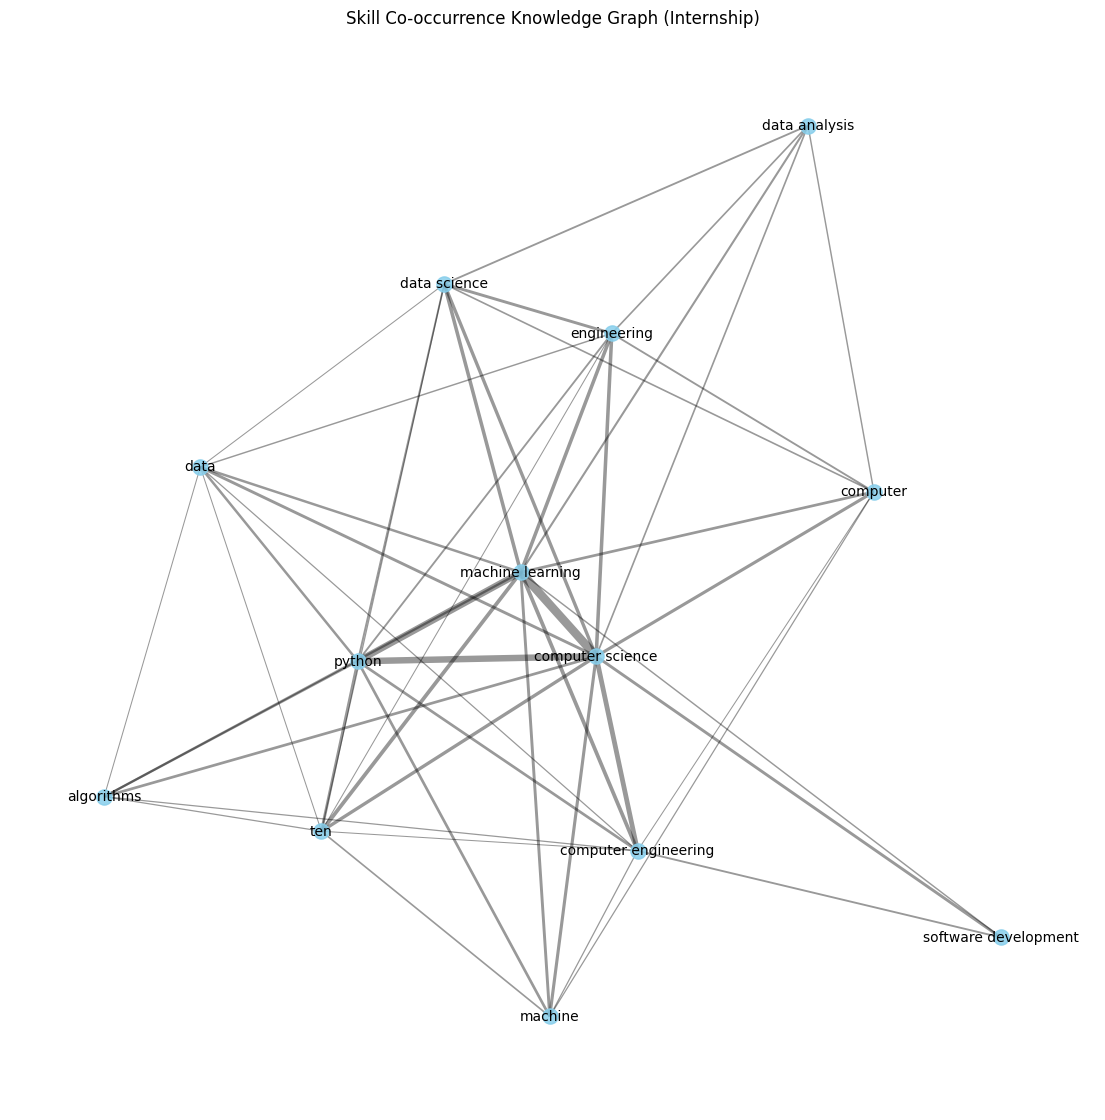

In [67]:
import matplotlib.pyplot as plt

#filter weak edges-reduce noise
MIN_EDGE_WEIGHT = 5

H = nx.Graph(
    (u, v, d) for u, v, d in G.edges(data=True)
    if d.get("weight", 0) >= MIN_EDGE_WEIGHT
)

plt.figure(figsize=(14, 14))

pos = nx.spring_layout(H, seed=42, k=0.6)

#draw edges
nx.draw_networkx_nodes(
    H, pos,
    node_size=120,
    node_color="skyblue",
    alpha=0.85
)

#draw edges
edge_weights = [d["weight"] for _, _, d in H.edges(data=True)]
nx.draw_networkx_edges(
    H, pos,
    width=[w * 0.15 for w in edge_weights],
    alpha=0.4
)

top_nodes = sorted(H.degree, key=lambda x: x[1], reverse=True)[:15]
labels = {n: n for n, _ in top_nodes}

nx.draw_networkx_labels(
    H, pos,
    labels,
    font_size=10
)

plt.title("Skill Co-occurrence Knowledge Graph (Internship)")
plt.axis("off")
plt.show()



Second Step, we count how often each extracted skill appears in internship job descriptions. To reduce noise, we keep only frequently occurring skills. Using these filtered skills, we construct a knowledge graph where nodes represent skills and edges represent skill co-occurrence within the same job description.

In [68]:
import networkx as nx
from itertools import combinations
from collections import Counter

# Count skill frequency
skill_freq = Counter()

for skills in df_intern["hard_skills"]:
    if isinstance(skills, list):
        for s in skills:
            if isinstance(s, str) and len(s) > 2:
                skill_freq[s.lower().strip()] += 1

# Keep only frequent skills
MIN_SKILL_FREQ = 15
valid_skills = {
    s for s, c in skill_freq.items() if c >= MIN_SKILL_FREQ
}

# Build filtered graph
G = nx.Graph()

for skills in df_intern["hard_skills"]:
    if not isinstance(skills, list):
        continue

    clean = [
        s.lower().strip()
        for s in skills
        if s.lower().strip() in valid_skills
    ]

    for a, b in combinations(set(clean), 2):
        if G.has_edge(a, b):
            G[a][b]["weight"] += 1
        else:
            G.add_edge(a, b, weight=1)

print("Filtered nodes:", G.number_of_nodes())
print("Filtered edges:", G.number_of_edges())


Filtered nodes: 13
Filtered edges: 75


To further simplify the graph, we remove weak relationships by keeping only edges whose co-occurrence frequency exceeds a predefined threshold. This step helps eliminate incidental relationships and highlights stronger associations between skills.

In [69]:
EDGE_THRESHOLD = 10

H = nx.Graph(
    (u, v, d) for u, v, d in G.edges(data=True)
    if d["weight"] >= EDGE_THRESHOLD
)


Finally, we visualize the filtered knowledge graph using a force-based layout. Related skills are positioned closer together, while unrelated skills are pushed apart. To improve readability, only the most connected skills are labeled.

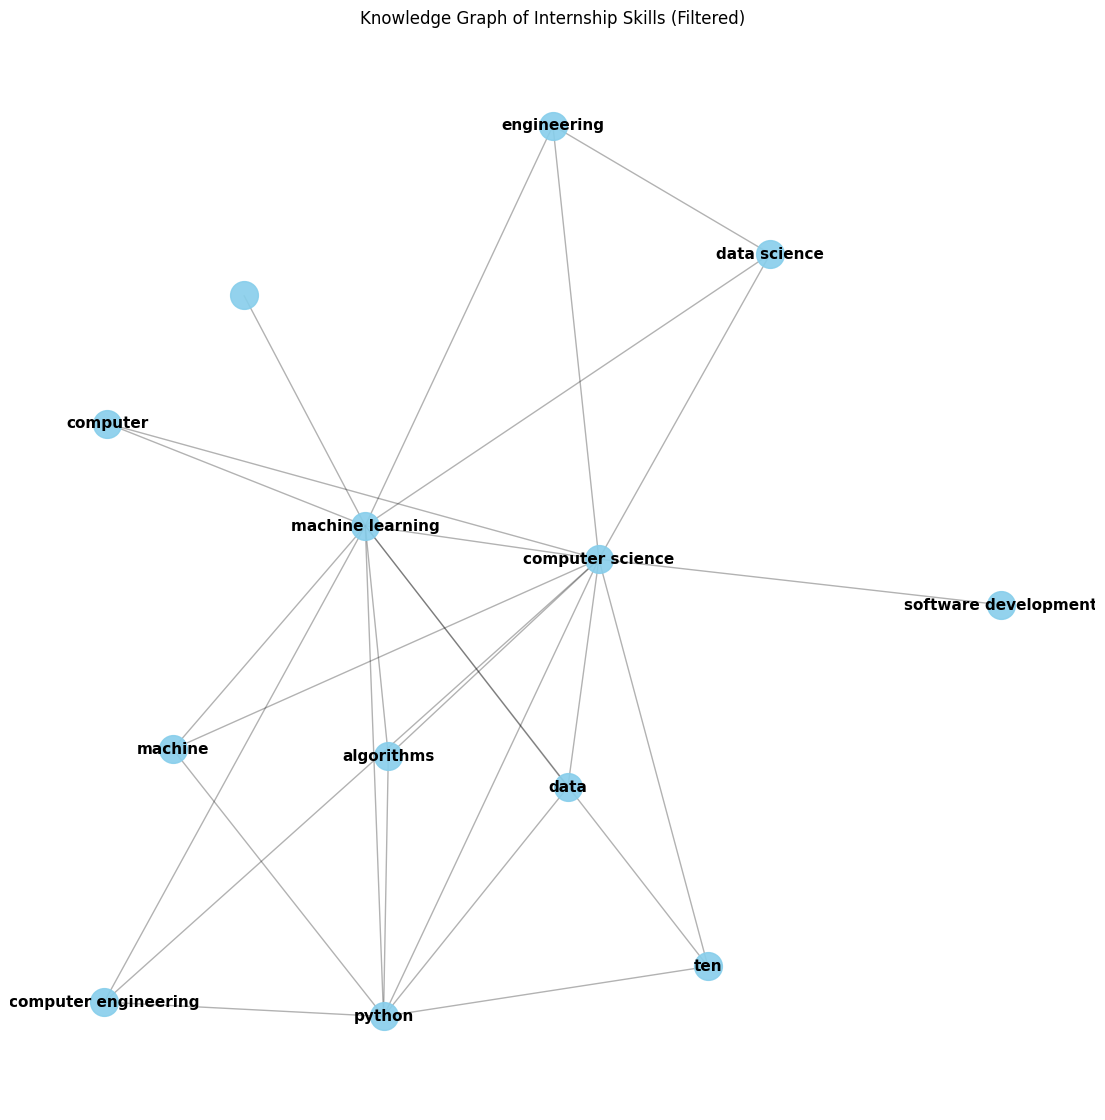

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))

pos = nx.kamada_kawai_layout(H)

nx.draw_networkx_nodes(
    H, pos,
    node_size=400,
    node_color="skyblue",
    alpha=0.9
)

nx.draw_networkx_edges(
    H, pos,
    alpha=0.3,
    width=1
)

#label only important nodes
top_nodes = sorted(H.degree, key=lambda x: x[1], reverse=True)[:12]
labels = {n: n for n, _ in top_nodes}

nx.draw_networkx_labels(
    H, pos,
    labels,
    font_size=11,
    font_weight="bold"
)

plt.title("Knowledge Graph of Internship Skills (Filtered)")
plt.axis("off")
plt.show()


### **Word Cloud Map**

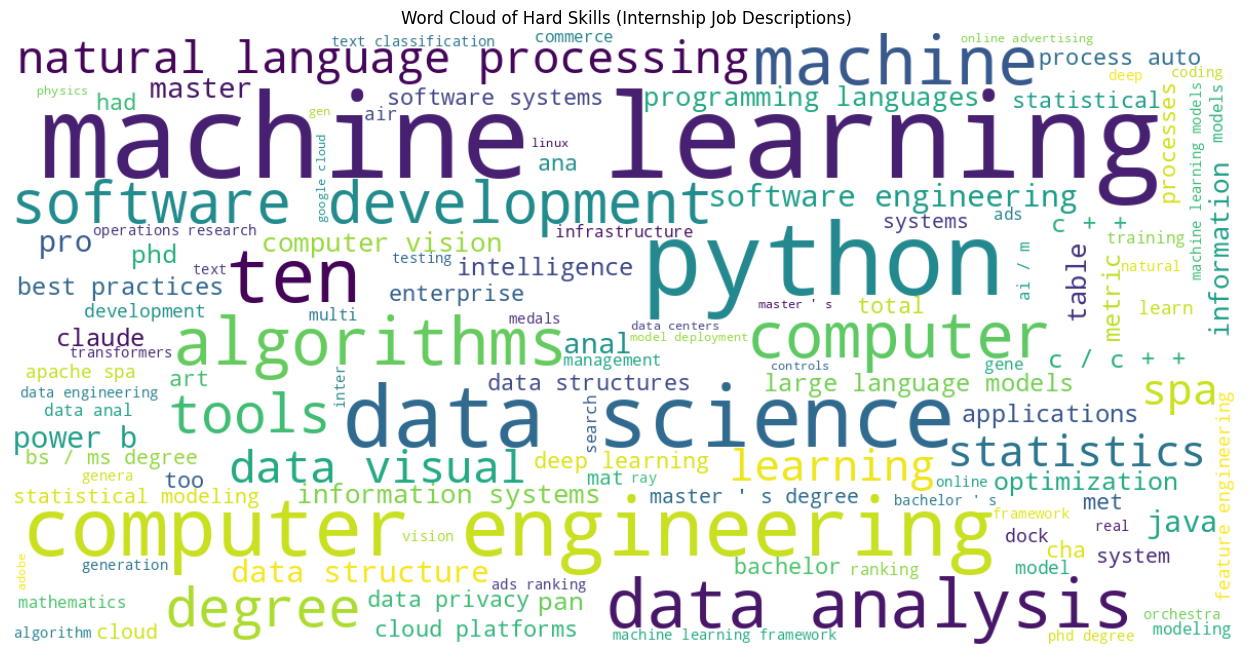

In [71]:
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud


all_hard = []
for skills in df_intern["hard_skills"]:
    if isinstance(skills, list):
        all_hard.extend([s for s in skills if isinstance(s, str)])


def wc_clean(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = s.strip(" ,;:.-/|()[]{}")
    return s

cleaned = []
for s in all_hard:
    s = wc_clean(s)
    if len(s) < 3:
        continue
    cleaned.append(s)

#remove the most generic words that usually add noise
stop = {"data", "science", "engineering", "computer science", "internship"}
cleaned = [s for s in cleaned if s not in stop]


freq = Counter(cleaned)

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=120,
    collocations=False
).generate_from_frequencies(freq)

plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Hard Skills (Internship Job Descriptions)")
plt.show()


## **Skill Extraction From CV  using JobBert**
In this step, we use JobBERT to extract job-related skills from CVs and examine how effectively the model performs on this data.

In [72]:
cv_path = "/content/jamesbond_DATASCIENCE._resumecsv.csv"
cv_df = pd.read_csv(cv_path)

col = cv_df.columns[0]
lines = cv_df[col].dropna().astype(str).tolist()

# quick check
print("Rows:", len(lines))
print(lines[:12])



Rows: 37
['Germany | (+49)10066078566 | jamesbond@siemens-energy.com | ', 'SKILLS', 'Programming & Tools                  Data Science & Machine Learning        Data Storage & Cloud', 'Python, R, C, Haskell, JavaScript,     Pytorch, TensorFlow, Pandas,         SQL, MongoDB, HDF5,', 'MPI, OpenMP                           NumPy, Matplotlib, SVM, ARIMA,          Snowflake, AWS,', 'SVR, Smoothing, FFT, ANOVA            Sagemaker, Lambda', 'functions, EMR', 'OpenCV, Yocto, Docker                PowerBI, Shiny, PCA, t-SNE, UMAP       Azure IoT Edge, Azure', 'Time series Insights', 'EXPERIENCE', 'Siemens-Energy | Internship - AI and Data Science Engineer        Erlangen | 07.2024 – Present', '■ Analyzed large gas turbine sensor data from T3000 systems to develop predictive maintenance']


We extract specific sections from the CV by locating section titles and capturing all text until the next section begins. This allows us to isolate relevant content, such as the Skills and Experience sections, for focused analysis.

In [73]:
def extract_section(lines, start_title, end_titles):
    start_idx = None
    end_idx = None

    for i, s in enumerate(lines):
        if s.strip().upper() == start_title.upper():
            start_idx = i + 1
            break

    if start_idx is None:
        return ""

    for j in range(start_idx, len(lines)):
        if lines[j].strip().upper() in {t.upper() for t in end_titles}:
            end_idx = j
            break

    if end_idx is None:
        end_idx = len(lines)

    section_lines = lines[start_idx:end_idx]
    return "\n".join(section_lines).strip()

skills_text = extract_section(lines, "SKILLS", ["EXPERIENCE", "EDUCATION", "PROJECTS"])
exp_text    = extract_section(lines, "EXPERIENCE", ["EDUCATION", "PROJECTS", "CERTIFICATIONS"])

print("SKILLS section preview:\n", skills_text[:400])


SKILLS section preview:
 Programming & Tools                  Data Science & Machine Learning        Data Storage & Cloud
Python, R, C, Haskell, JavaScript,     Pytorch, TensorFlow, Pandas,         SQL, MongoDB, HDF5,
MPI, OpenMP                           NumPy, Matplotlib, SVM, ARIMA,          Snowflake, AWS,
SVR, Smoothing, FFT, ANOVA            Sagemaker, Lambda
functions, EMR
OpenCV, Yocto, Docker                Power


We load two JobBERT-based token classification models to identify skill-related information in text. To handle long CV sections, the text is split into smaller chunks based on whitespace so that each part fits within the model’s input limits. Each chunk is processed separately by the models, and the results are combined to extract skills from the relevant CV sections (in the next three cells).

In [74]:
from transformers import pipeline

soft_skill_pipeline = pipeline(
    "token-classification",
    model="jjzha/jobbert_skill_extraction",
    aggregation_strategy="simple"
)

hard_skill_pipeline = pipeline(
    "token-classification",
    model="jjzha/jobbert_knowledge_extraction",
    aggregation_strategy="simple"
)



Device set to use cuda:0
Device set to use cuda:0


In [75]:
def chunk_on_whitespace(text, max_chars=900):
    text = text.strip()
    chunks = []
    i = 0
    n = len(text)

    while i < n:
        end = min(i + max_chars, n)

        # if we aren't at the end, move 'end' back to last whitespace
        if end < n:
            back = text.rfind(" ", i, end)
            if back != -1 and back > i + 50:  # avoid tiny chunks
                end = back

        chunks.append(text[i:end].strip())
        i = end

    return [c for c in chunks if c]



In [76]:
def run_pipe_chunked(text, pipe):
    results = []
    for ch in chunk_on_whitespace(text, max_chars=900):
        results.extend(pipe(ch))
    return results

hard_results = run_pipe_chunked(skills_text, hard_skill_pipeline)   # best for tech skills
soft_results = run_pipe_chunked(exp_text, soft_skill_pipeline)      # better than whole CV


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


We clean the raw model outputs by removing subword markers, extra spaces, punctuation, and common non-skill words. This step reduces noise and produces a more meaningful and deduplicated list of extracted skills for analysis

In [77]:
def clean_extracted_words(words):
    cleaned = []
    for w in words:
        w = w.replace("##", "").strip()
        w = re.sub(r"\s+", " ", w)
        w = w.strip(" ,;:.-/|()[]{}")

        # drop junk/fragments
        if len(w) < 2:
            continue
        if w.lower() in {"and", "or", "the", "a", "an", "to", "of"}:
            continue

        cleaned.append(w)

    return sorted(set(cleaned))

soft_skills = clean_extracted_words([r["word"] for r in soft_results])
hard_skills = clean_extracted_words([r["word"] for r in hard_results])

print("Soft skills found:", len(soft_skills))
print("Hard skills found:", len(hard_skills))

soft_skills[:30], hard_skills[:50]


Soft skills found: 21
Hard skills found: 37


(['Analyzed',
  'Developed',
  'an efficient IoT edge platform',
  'data - driven solutions',
  'develop',
  'embedded systems and cloud APIs',
  'implementing',
  'integrating',
  'large gas turbine sensor data',
  'microservices infrastructure',
  'optimize',
  'plant operations and maintenance scheduling',
  'power plant health monitoring dashboard',
  'predictive maintenance insights',
  'processing',
  'real - time data',
  'real - time metrics and analytics',
  'time - series aggregation pipeline',
  '■ Architected',
  '■ Built',
  '■ Implemented'],
 ['ANOVA',
  'ARIMA',
  'AWS',
  'Azure',
  'Cloud',
  'Data',
  'Docker PowerBI',
  'EMR OpenCV',
  'FFT',
  'HDF5',
  'JavaScript',
  'Lambda',
  'Learning',
  'MPI',
  'Machine',
  'Matplotlib',
  'OpenMP NumPy',
  'PCA, t - SNE',
  'Pandas',
  'Python',
  'Pytorch',
  'R, C, Haskell',
  'SQL, MongoDB',
  'SVM',
  'SVR',
  'Sage',
  'Science',
  'Shiny',
  'Smoothing',
  'Snowflake',
  'Storage',
  'TensorFlow',
  'Time series Insi

We apply a simple rule-based method to split the skills section by commas and line breaks in order to extract individual skill entries. Headings and non-skill labels are removed to produce a cleaner list of hard skills for comparison.

In [78]:
def split_commas(text):
    items = re.split(r"[,\n]\s*", text)
    items = [i.strip() for i in items if i.strip()]
    # remove headings-like lines
    items = [i for i in items if i.upper() not in {"PROGRAMMING & TOOLS", "DATA SCIENCE", "ML", "AI"}]
    return sorted(set(items))

hard_skills_rule = split_commas(skills_text)

print("Hard skills (rule-based) sample:", hard_skills_rule[:50])



Hard skills (rule-based) sample: ['ANOVA            Sagemaker', 'ARIMA', 'AWS', 'Azure', 'C', 'Docker                PowerBI', 'EMR', 'FFT', 'HDF5', 'Haskell', 'JavaScript', 'Lambda', 'MPI', 'Matplotlib', 'MongoDB', 'OpenCV', 'OpenMP                           NumPy', 'PCA', 'Pandas', 'Programming & Tools                  Data Science & Machine Learning        Data Storage & Cloud', 'Python', 'Pytorch', 'R', 'SQL', 'SVM', 'SVR', 'Shiny', 'Smoothing', 'Snowflake', 'TensorFlow', 'Time series Insights', 'UMAP       Azure IoT Edge', 'Yocto', 'functions', 't-SNE']


In [79]:
hard_skills_combined = sorted(set(hard_skills) | set(hard_skills_rule))
hard_skills_combined[:80]

['ANOVA',
 'ANOVA            Sagemaker',
 'ARIMA',
 'AWS',
 'Azure',
 'C',
 'Cloud',
 'Data',
 'Docker                PowerBI',
 'Docker PowerBI',
 'EMR',
 'EMR OpenCV',
 'FFT',
 'HDF5',
 'Haskell',
 'JavaScript',
 'Lambda',
 'Learning',
 'MPI',
 'Machine',
 'Matplotlib',
 'MongoDB',
 'OpenCV',
 'OpenMP                           NumPy',
 'OpenMP NumPy',
 'PCA',
 'PCA, t - SNE',
 'Pandas',
 'Programming & Tools                  Data Science & Machine Learning        Data Storage & Cloud',
 'Python',
 'Pytorch',
 'R',
 'R, C, Haskell',
 'SQL',
 'SQL, MongoDB',
 'SVM',
 'SVR',
 'Sage',
 'Science',
 'Shiny',
 'Smoothing',
 'Snowflake',
 'Storage',
 'TensorFlow',
 'Time series Insight',
 'Time series Insights',
 'UMAP       Azure IoT Edge',
 'UMAP Azure IoT Edge',
 'Yocto',
 'functions',
 'maker',
 't-SNE']

**Output:** The output extracted several correct hard skills, such as **Python, R, C, SQL, TensorFlow, PyTorch, AWS, Docker, and MongoDB.** However, it also produces noisy outputs where multiple skills or headings are incorrectly merged, for example **“ANOVA Sagemaker”, “Docker PowerBI”, and “OpenMP NumPy”**. In some cases, section titles like “Programming & Tools Data Science & Machine Learning Data Storage & Cloud”.

However, skill extraction from CVs was relatively easier because the dataset was small, whereas the job description dataset was much larger and more complex.

## **Skill finding with Bert Topic**

**BERTopic is a wrong choice for skill extraction.** It groups words based on semantic similarity and designed to discover topics, not to identify exact skill names. It often mixes skills with tasks and contextual words, resulting in noisy outputs.

In otherway, BERTopic is better suited for exploratory analysis, while JobBERT is more appropriate for accurate skill identification. Even so, we aim to observe the structure and quality of the generated output

We apply a cleaning function to remove invalid or noisy skill entries. Very short tokens, punctuation-only strings, and common non-skill words are filtered out, leaving a cleaner and more meaningful set of extracted skills.

In [81]:
import string

def clean_skill_list(skills):
    cleaned = []
    for s in skills:
        s = s.lower().strip()

        if len(s) < 3:
            continue

        if all(c in string.punctuation for c in s):
            continue

        junk = {"and", "with", "using", "use", "work", "the", "a", "an", "to", "of"}
        if s in junk:
            continue

        cleaned.append(s)

    return list(set(cleaned))



We clean the extracted skill lists to remove noise and then convert them into text documents by joining the remaining skills.

In [83]:
df_intern["soft_skills_clean"] = df_intern["soft_skills"].apply(clean_skill_list)
df_intern["hard_skills_clean"] = df_intern["hard_skills"].apply(clean_skill_list)

df_intern["soft_doc"] = df_intern["soft_skills_clean"].apply(lambda x: " ".join(x))
df_intern["hard_doc"] = df_intern["hard_skills_clean"].apply(lambda x: " ".join(x))

df_intern[["soft_doc", "hard_doc"]].head()




,soft_doc,hard_doc
0,energetic machine learning solutions with stra...,data machine learning models cloud machine com...
5,participate in a full - time team player commu...,"anal r , mat programming languages computer ma..."
24,platform teams deliver end - to - end solution...,gene image processing programming languages co...
28,"team player problems modeling communication , ...",mat statistical modeling computer science comp...
36,solutions to problems in a clear and con think...,pregnancy computer science computer engineerin...


We remove entries with empty skill content and keep only documents that contain extracted skills. The cleaned skill documents are then renamed to a standard format and saved as separate files for soft and hard skills, allowing them to be used as input for topic modeling.

In [84]:
soft_df = df_intern[df_intern["soft_doc"].str.strip() != ""][["soft_doc"]].copy()
hard_df = df_intern[df_intern["hard_doc"].str.strip() != ""][["hard_doc"]].copy()

soft_df.rename(columns={"soft_doc": "document"}, inplace=True)
hard_df.rename(columns={"hard_doc": "document"}, inplace=True)

soft_df.to_csv("/content/soft_skills_docs.csv", index=False)
hard_df.to_csv("/content/hard_skills_docs.csv", index=False)

print("Soft docs:", len(soft_df))
print("Hard docs:", len(hard_df))

Soft docs: 69
Hard docs: 69


In [85]:
soft_df = pd.read_csv("/content/soft_skills_docs.csv")
hard_df = pd.read_csv("/content/hard_skills_docs.csv")

soft_docs = soft_df["document"].tolist()
hard_docs = hard_df["document"].tolist()


In [90]:
#soft skills
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

umap_model = UMAP(
    n_neighbors=5,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

soft_topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    language="english",
    verbose=True
)

soft_topics, _ = soft_topic_model.fit_transform(soft_docs)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2026-01-05 21:40:24,589 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-05 21:40:25,294 - BERTopic - Embedding - Completed ✓
2026-01-05 21:40:25,298 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-05 21:40:36,574 - BERTopic - Dimensionality - Completed ✓
2026-01-05 21:40:36,575 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-05 21:40:36,582 - BERTopic - Cluster - Completed ✓
2026-01-05 21:40:36,584 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-05 21:40:36,604 - BERTopic - Representation - Completed ✓


In [91]:
#hard skills.
hard_topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    language="english",
    verbose=True
)

hard_topics, _ = hard_topic_model.fit_transform(hard_docs)


2026-01-05 21:40:42,719 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-05 21:40:42,836 - BERTopic - Embedding - Completed ✓
2026-01-05 21:40:42,837 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-05 21:40:42,918 - BERTopic - Dimensionality - Completed ✓
2026-01-05 21:40:42,919 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-05 21:40:42,925 - BERTopic - Cluster - Completed ✓
2026-01-05 21:40:42,929 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-05 21:40:42,939 - BERTopic - Representation - Completed ✓


In [92]:
import pandas as pd

def topic_table_like_bertopic(topic_model, top_n_words=10):
    info_df = topic_model.get_topic_info()

    rows = []

    for _, row in info_df.iterrows():
        topic_id = row["Topic"]
        count = row["Count"]


        if topic_id == -1:
            continue

        words = topic_model.get_topic(topic_id)
        if words is None:
            continue

        keywords = [w for w, _ in words][:top_n_words]


        if len(keywords) < top_n_words:
            keywords += [""] * (top_n_words - len(keywords))

        rows.append({
            "Topic": topic_id,
            "Count": count,
            "Top Keywords": ", ".join(keywords)
        })

    return pd.DataFrame(rows)



In [93]:
soft_topic_table = topic_table_like_bertopic(soft_topic_model)
soft_topic_table.head()

,Topic,Count,Top Keywords
0,0,59,"and, data, to, the, work, of, with, skills, le..."
1,1,10,"end, the, and, authorization, of, search, work..."


In [94]:
hard_topic_table = topic_table_like_bertopic(hard_topic_model)
hard_topic_table.head()

,Topic,Count,Top Keywords
0,0,40,"learning, computer, machine, data, engineering..."
1,1,9,"data, science, information, systems, metric, a..."
2,2,7,"development, software, data, computer, design,..."


In [95]:
from collections import Counter

all_soft_skills = []

for skills in df_intern["soft_skills_clean"]:
    all_soft_skills.extend(skills)

soft_skill_counts = Counter(all_soft_skills)

soft_skill_freq_df = (
    pd.DataFrame(soft_skill_counts.items(), columns=["skill", "count"])
      .sort_values("count", ascending=False)
)

soft_skill_freq_df.head(20)


,skill,count
10,dev,21
104,communication skills,15
157,pro,13
35,data,11
116,problem - solving,11
301,auto,11
194,programming,10
123,handling and managing confidential information,10
122,sound judgment,10
31,science,10


In [96]:
all_hard_skills = []

for skills in df_intern["hard_skills_clean"]:
    all_hard_skills.extend(skills)

hard_skill_counts = Counter(all_hard_skills)

hard_skill_freq_df = (
    pd.DataFrame(hard_skill_counts.items(), columns=["skill", "count"])
      .sort_values("count", ascending=False)
)

hard_skill_freq_df.head(20)


,skill,count
4,computer science,58
10,machine learning,48
5,python,39
38,computer engineering,24
63,ten,20
6,data science,19
9,engineering,18
3,machine,17
108,algorithms,16
0,data,16
